# notebook containing examples of how to use BMplot

/Users/gregglickert/opt/anaconda3/envs/bmtk/lib/python3.8/site-packages/bmtool/bmplot.py:278: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


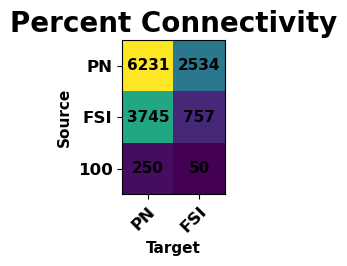

In [3]:
from bmtool import bmplot
bmplot.percent_connection_matrix(config='config.json',sources = ['all'],targets=['all'],sids = ['pop_name'],tids = ['pop_name'],no_prepend_pop=True)